### Imports

In [1]:
import itertools
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from bs4 import BeautifulSoup
from collections import Counter
from itertools import chain
from pandas.io.json import json_normalize
from pprint import pprint
from recipe_scrapers import scrape_me
from pymongo import MongoClient
from selenium import webdriver
from selenium.common.exceptions import TimeoutException, ElementNotInteractableException
from selenium.common.exceptions import ElementNotVisibleException, StaleElementReferenceException
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.support import expected_conditions as EC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from tqdm import tqdm_notebook as tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

### Create Parser for Cleaning Ingredients

In [31]:
# regex for separating ingredients list
SEPARATOR_RE = re.compile(r'^([\d\s*[\d\.,/]*)\s*(.+)')

# create a normalized string for ingredients
def normalize(st):
    """

    :param st:
    :return:
    """
    return re.sub(r'\s+', ' ', SEPARATOR_RE.sub('\g<1> \g<2>', st)).strip()


def escape_re_string(text):
    """

    :param text:
    :return:
    """
    text = text.replace('.', '\.')
    return re.sub(r'\s+', ' ', text)

# list of common units of measurements for ingredients
UNITS = {"cup": ["cups", "cup", "c.", "c"], "fluid_ounce": ["fl. oz.", "fl oz", "fluid ounce", "fluid ounces"],
         "gallon": ["gal", "gal.", "gallon", "gallons"], "ounce": ["oz", "oz.", "ounce", "ounces"],
         "pint": ["pt", "pt.", "pint", "pints"], "pound": ["lb", "lb.", "pound", "pounds"],
         "quart": ["qt", "qt.", "qts", "qts.", "quart", "quarts"],
         "tablespoon": ["tbsp.", "tbsp", "T", "T.", "tablespoon", "tablespoons", "tbs.", "tbs"],
         "teaspoon": ["tsp.", "tsp", "t", "t.", "teaspoon", "teaspoons"],
         "gram": ["g", "g.", "gr", "gr.", "gram", "grams"], "kilogram": ["kg", "kg.", "kilogram", "kilograms"],
         "liter": ["l", "l.", "liter", "liters"], "milligram": ["mg", "mg.", "milligram", "milligrams"],
         "milliliter": ["ml", "ml.", "milliliter", "milliliters"], "pinch": ["pinch", "pinches"],
         "dash": ["dash", "dashes"], "touch": ["touch", "touches"], "handful": ["handful", "handfuls"],
         "stick": ["stick", "sticks"], "clove": ["cloves", "clove"], "can": ["cans", "can"], "large": ["large"],
         "small": ["small"], "scoop": ["scoop", "scoops"], "filets": ["filet", "filets"], 
         "fillets": ["fillet", "fillets"], "sprig": ["sprigs", "sprig"],"jar":["jar","jars"], 
         "packet": ["packet","packets"], "package": ["package","packages"], "bottle":["bottle","bottles"],
         "slice":["slice","slices"], "cube":["cube","cubes"], "container":["container","containers"],
         "envelope":["envelope","envelopes"], "ground":["ground"], "quick":["quick"], "bunch":["bunch"]}

# numbers to separate quantities from ingredients
NUMBERS = ['seventeen', 'eighteen', 'thirteen', 'nineteen', 'fourteen', 'sixteen', 'fifteen', 'seventy', 'twelve',
           'eleven', 'eighty', 'thirty', 'ninety', 'twenty', 'seven', 'fifty', 'sixty', 'forty', 'three', 'eight',
           'four', 'zero', 'five', 'nine', 'ten', 'one', 'six', 'two', 'an', '½', '⅓','⅔','¼','¾','⅕','⅛','half',
          'halves','pieces','cubes','chunks','whole','cube', 'extra', 'pieces','piece','cube', 'long', 'jumbo', 'small',
          'medium', 'large', ]

prepositions = ["of"]

a = list(itertools.chain.from_iterable(UNITS.values()))
a.sort(key=lambda x: len(x), reverse=True)
a = map(escape_re_string, a)

PARSER_RE = re.compile(
    r'(?P<quantity>(?:[\d\.,][\d\.,\s/]*)?\s*(?:(?:%s)\s*)*)?(\s*(?P<unit>%s)\s+)?(\s*(?:%s)\s+)?(\s*(?P<name>.+))?' % (
        '|'.join(NUMBERS), '|'.join(a), '|'.join(prepositions)))


def parse(st):
    """

    :param st:
    :return:
    """
    st = normalize(st)
    res = PARSER_RE.match(st)
    
    return ((res.group('name') or '').strip())

### Load DataFrame of Recipes

In [2]:
df = pd.read_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/6k_clean.csv',index_col=0)

In [3]:
# preview head
df.head()

,name,ingredients,clean
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']","['sweet Italian sausage', 'lean ground beef', ' onion', 'garlic', ' tomatoes', 'tomato paste', ' tomato sauce', 'water', 'white sugar', ' basil leaves', 'fennel seeds', 'Italian seasoning', 'salt', 'ground black pepper', ' fresh parsley', 'lasagna noodles', 'ricotta cheese', 'egg', 'mozzarella cheese', ' Parmesan cheese']"
1,Pork Chops in Garlic Mushroom Sauce,"['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']","['pork chops', 'paprika', 'kosher salt and ground black pepper to taste', 'butter', 'package fresh mushrooms', 'garlic', 'Dijon mustard', 'all-purpose flour', 'beef broth']"
2,Super Duper Slow Cooker Beef Stroganoff,"['1 1/2 pounds cubed beef stew meat', 'salt and ground black pepper to taste', '1 onion, chopped', '1 (10.75 ounce) can condensed cream of mushroom soup', '1/4 cup water', '1 tablespoon dried chives', '2 cloves garlic, minced', '1 tablespoon Worcestershire sauce', '1 cube beef bouillon', '1/2 cup red wine', '1 tablespoon cornstarch', '1 tablespoon all-purpose flour', '1 (8 ounce) container sour cream', '1 (8 ounce) package sliced fresh mushrooms', '4 ounces cream cheese', '1/2 cup chopped fresh parsley']","[' beef stew meat', 'salt and ground black pepper to taste', 'onion', ' cream of mushroom soup', 'water', ' chives', 'garlic', 'Worcestershire sauce', 'cube beef bouillon', ' wine', 'cornstarch', 'all-purpose flour', 'container sour cream', 'package fresh mushrooms', 'cream cheese', ' fresh parsley']"
3,Chef John's Perfect Prime Rib,"['4 pounds prime rib roast', '1/4 cup unsalted butter, softened', '1 tablespoon freshly ground black pepper', '1 teaspoon herbes de Provence', 'kosher salt']","['prime rib roast', ' butter', ' ground black pepper', 'herbes de Provence', 'kosher salt']"
4,Beef Stroganoff for Instant Pot®,"['2 tablespoons canola oil', '1/2 onion, diced', '2 teaspoons salt, divided', '2 pounds beef stew meat, cut into 1-inch cubes', '1 teaspoon freshly ground black pepper', '3 cloves garlic, minced', '1/2 teaspoon dried thyme', '2 tablespoons soy sauce', '3 cups chopped mushrooms', '2 tablespoons all-purpose flour', '3 cups chicken broth', '1 (16 ounce) package wide egg noodles', '3/4 cup sour cream, or to taste']","['canola oil', 'onion', 'salt', 'beef stew meat', ' ground black pepper', 'garlic', ' thyme', 'soy sauce', ' mushrooms', 'all-purpose flour', 'chicken broth', 'package wide egg noodles', 'sour cream']"


In [17]:
# change ingredients string to a list of strings, remove punctuations
def list_me(string): 
    li = list(string.replace("'","").replace("[","").replace("]","").split(","))
    return li

In [32]:
# iterate through DataFrame and create nested list of clean ingredients
clean_ings = []
for values in df.clean:
    helping = []
    for string in list_me(values):
        helping.append(parse(string))
    clean_ings.append(helping)

In [37]:
# add the nested list back to the DataFrame and drop the old clean column
df['cleaned_ings'] = clean_ings
df.drop(columns=['clean'],inplace=True)

In [57]:
# load in DataFrame with avg. rating and total time for recipe completion
df1 = pd.read_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/CSV Files/7k_noreviews.csv',index_col=0)
df1.drop(columns=['ingredients'],inplace=True)

In [59]:
# merge the DataFrames by name of recipe
df = df.merge(df1,left_on="name", right_on="name")

In [61]:
# sort the DataFrame by the cooking time
df.sort_values(by=['total time (min)'])

,name,ingredients,cleaned_ings,total time (min),avg. rating
2967,Chinese Noodle Chicken,"['4 skinless, boneless chicken breasts', '1 tablespoon vegetable oil', '½ cup sliced onion', '2 cups broccoli florets', '2 carrots, julienned', '2 cups snow peas', '4 cups dry Chinese noodles', '¼ cup teriyaki sauce']","[chicken breasts, vegetable oil, onion, broccoli florets, carrots, snow peas, dry Chinese noodles, teriyaki sauce]",0.0,4.23
1606,Rolled Dumplings,"['2 cups all-purpose flour', '2 teaspoons baking powder', '1 teaspoon salt', '1/3 cup shortening', '1/2 cup milk', '2 (14.5 ounce) cans chicken broth']","[all-purpose flour, baking powder, salt, shortening, milk, chicken broth]",0.0,4.69
1610,Baked Asian-Style Honey Chicken,"['1 (3 pound) whole chicken, cut into pieces', '3 tablespoons chopped onion', '2 tablespoons soy sauce', '1 tablespoon minced fresh ginger root', '1 teaspoon minced garlic', '2 tablespoons honey', '¼ cup chopped green onions']","[chicken, onion, soy sauce, fresh ginger root, garlic, honey, green onions]",0.0,4.28
1620,Tomato and Garlic Pasta,"['1 (8 ounce) package angel hair pasta', '2 pounds tomatoes', '4 cloves crushed garlic', '1 tablespoon olive oil', '1 tablespoon chopped fresh basil', '1 tablespoon tomato paste', 'salt to taste', 'ground black pepper to taste', '1/4 cup grated Parmesan cheese']","[angel hair pasta, tomatoes, garlic, olive oil, fresh basil, tomato paste, salt to taste, black pepper to taste, Parmesan cheese]",0.0,4.44
4076,Penne with Red Pepper Sauce and Broccoli,"['4 tablespoons olive oil', '1 ½ cups chopped onion', '2 cloves garlic, minced', '2 red bell peppers, chopped', '¼ cup almonds', '2 teaspoons balsamic vinegar', '½ teaspoon salt', 'freshly ground black pepper', '⅛ teaspoon cayenne pepper', '4 cups broccoli florets', '1 pound penne pasta', '⅓ cup grated Parmesan cheese', '½ cup fresh basil leaves, cut into thin strips']","[olive oil, onion, garlic, bell peppers, almonds, balsamic vinegar, salt, black pepper, cayenne pepper, broccoli florets, penne pasta, Parmesan cheese, fresh basil leaves]",0.0,4.13
1625,Turkey Pot Pie II,"['1 recipe pastry for a 9 inch double crust pie', '2 cups cubed cooked turkey', '2 cups frozen mixed vegetables, thawed', '2 tablespoons chopped onion', '1 (10.75 ounce) can condensed cream of chicken soup', '1/2 cup milk']","[recipe pastry for a 9 inch double crust pie, turkey, frozen vegetables, onion, cream of chicken soup, milk]",0.0,4.64
5146,Portuguese Cod Fish Casserole,"['2 pounds salted cod fish', '5 large potatoes, peeled and sliced', '3 large onions, sliced', '3/4 cup olive oil', '2 cloves garlic, minced', '1 tablespoon chopped fresh parsley', '1 1/2 teaspoons crushed red pepper flakes', '1 teaspoon paprika', '3 tablespoons tomato sauce']","[cod fish, potatoes, onions, olive oil, garlic, fresh parsley, pepper flakes, paprika, tomato sauce]",0.0,4.35
1626,"Pasta, Broccoli and Chicken","['12 ounces rigatoni pasta', '½ pound fresh broccoli florets', '¼ cup olive oil', '1 tablespoon minced garlic', '2 tablespoons pesto', '1 cup chopped tomatoes', '¾ cup grated Parmesan cheese', '1 pound boneless chicken breast halves, cooked and chopped', 'salt to taste', 'ground black pepper to taste']","[rigatoni pasta, fresh broccoli florets, olive oil, garlic, pesto, tomatoes, Parmesan cheese, chicken breast halves, salt to taste, black pepper to taste]",0.0,4.47
4075,Ricotta Stuffed Squash,"['8 yellow squash', '2 tablespoons butter', '1 onion, chopped', '1 clove garlic, minced', '1 (10 ounce) package frozen chopped spinach, thawed', '2 eggs', '2 cups ricotta cheese', '1/4 cup grated Parmesan cheese', '1 tablespoon chopped fresh parsley', '1/2 teaspoon salt', '1 teaspoon Italian seasoning', '1 pinch ground black pepper', '1 (26 ounce) jar spaghetti sauce']","[yellow squash, butter, onion, garlic, frozen spinach, eggs, ricotta cheese, Parmesan cheese, fresh parsley, salt, Italian seasoning, black pepper, spaghetti sauce]",0.0,4.11
4074,Spinach Garlic Pasta,"['1 (16

In [64]:
# find the number of recipes with no/0 cooking time
len(df.loc[df['total time (min)'] == 0])

454

In [65]:
# sort by rating, see unrated items
df.sort_values(by=['avg. rating'])

,name,ingredients,cleaned_ings,total time (min),avg. rating
13,Al's Burmese Chicken Curry,"['1 teaspoon butter, or as needed', '8 shallots, thinly sliced', '3 tablespoons red curry paste, or more to taste', '2 tablespoons hot curry powder', '1 tablespoon ground red chile pepper', '2 1/2 pounds chicken thighs', '1 lemongrass, smashed and cut into 1-inch pieces', ""10 bird's eye chile peppers, chopped, or to taste"", '1 tablespoon ground coriander', '2 kaffir lime leaves, or to taste', '3 tablespoons fish sauce', 'water to cover', '1 (14 ounce) can coconut milk', '4 tomatoes, quartered', '1/2 small bunch fresh cilantro, chopped, or to taste']","[butter, shallots, curry paste, hot curry powder, chile pepper, chicken thighs, lemongrass, ""birds eye chile peppers"", coriander, kaffir lime leaves, fish sauce, water to cover, coconut milk, tomatoes, fresh cilantro]",180.0,0.00
14,Gemelli Pasta with Roasted Pumpkin and Pancetta,"['2 cups peeled, cubed pumpkin', '2 tablespoons extra-virgin olive oil, divided', '1 teaspoon fresh thyme', '1/4 teaspoon salt', '1/8 teaspoon ground black pepper', '1/2 (16 ounce) package gemelli pasta', '1 (4 ounce) package diced pancetta', '1 cup chicken broth', '1/4 cup grated Parmigiano-Reggiano cheese']","[, -virgin olive oil, fresh thyme, salt, black pepper, gemelli pasta, pancetta, chicken broth, Parmigiano-Reggiano cheese]",55.0,0.00
5396,Quick Polynesian Chicken,"['6 chicken thighs', '1 (15.25 ounce) can fruit cocktail']","[chicken thighs, fruit cocktail]",0.0,2.92
5217,Spinach Mushroom and Ricotta Fettuccine,"['1 (16 ounce) package spinach fettuccine pasta', '1 teaspoon butter', '3 cups mushrooms', '1 (10 ounce) package frozen chopped spinach', '1 (15 ounce) container ricotta cheese', '1 lemon, juiced']","[spinach fettuccine pasta, butter, mushrooms, frozen spinach, ricotta cheese, lemon]",30.0,2.93
3962,Old-Fashioned Chicken and Dumplings,"['1 (3 pound) whole chicken', '4 cubes chicken bouillon', '2 cups all-purpose flour', '4 eggs', '1 teaspoon salt']","[chicken, chicken bouillon, all-purpose flour, eggs, salt]",200.0,3.07
4755,Dee's Special Chicken,"['4 skinless, boneless chicken breast halves', 'salt and pepper to taste', '1 teaspoon dried rosemary', '1 teaspoon dried sage', '1 teaspoon dried thyme', '6 cloves garlic', '1 (12 fluid ounce) can or bottle beer', '2 sprigs fresh parsley, for garnish']","[chicken breast halves, salt and pepper to taste, rosemary, sage, thyme, garlic, or bottle beer, fresh parsley]",0.0,3.08
5294,Slow Cooker Chicken Curry with Quinoa,"['1 ½ pounds diced chicken breast meat', '¾ cup chopped onion', '1 ¼ cups chopped celery', '1 ¾ cups chopped Granny Smith apples', '1 cup chicken broth', '¼ cup nonfat milk', '1 tablespoon curry powder', '¼ teaspoon paprika', '⅓ cup quinoa']","[chicken breast meat, onion, celery, Granny Smith apples, chicken broth, nonfat milk, curry powder, paprika, quinoa]",270.0,3.15
5068,Chicken A La Orange,"['4 skinless, boneless chicken breasts', '1 tablespoon vegetable oil', '2 ½ cups orange juice', '3 tablespoons cornstarch', '½ cup hot water', '3 tablespoons honey', '¼ teaspoon ground ginger']","[chicken breasts, vegetable oil, orange juice, cornstarch, hot water, honey, ginger]",40.0,3.15
4130,Baked Zucchini Cakes,"['2 cups shredded zucchini', '1 cup Italian seasoned bread crumbs', '1 egg', '1 tablespoon mayonnaise', '1 teaspoon prepared mustard', '1 tablespoon Old Bay Seasoning TM']","[zucchini, Italian bread crumbs, egg, mayonnaise, mustard, Old Bay Seasoning TM]",55.0,3.19
5362,Chicken and Sweet Potato Bake,"['1 large McIntosh apple - peeled, cored, and diced', '2 sweet potatoes, peeled and cubed', '1 small onion, sliced', '1 teaspoon ground nutmeg', '1 teaspoon ground cinnamon', '1 teaspoon ground ginger', 'salt and pepper to taste', '2 bone-in chicken breast halves']","[McIntosh apple -, sweet potatoes, onion, nutmeg, cinnamon, ginger, salt and pepper to taste, bone-in chicken breast halves]",60.0,3.22


In [83]:
# find all the variations of chicken breast 
subs = 'chicken breast'

res = [i for sub_list in clean_ings for i in sub_list if subs in i]

print(str(res))

['chicken breast halves', 'chicken breast halves', 'chicken breast halves -', 'chicken breast halves', 'chicken breast halves', 'frozen chicken breast halves', 'chicken breast halves', 'chicken breast halves - 1/4 inch thick', 'chicken breast halves', 'chicken breast halves', 'chicken breast meat', 'chicken breast halves - cut into 1 inch cubes', 'chicken breast halves - cut into 1/2 inch strips', 'chicken breast halves -', 'chicken breast halves', 'chicken breasts', 'chicken breast halves', 'chicken breast halves', 'chicken breast halves', 'chicken breast halves', 'chicken breast halves - thin', 'chicken breasts', 'chicken breast halves', 'chicken breast halves', 'chicken breast meat - cut into chunks', 'chicken breast halves', 'chicken breast halves - cut into 1 inch cubes', 'chicken breast halves - to 1/2 inch thickness', 'chicken breasts', 'chicken breast halves', 'chicken breast halves', 'chicken breast halves', 'chicken breast meat -', 'chicken breast halves', 'chicken breast hal

In [131]:
# replace all instances of chicken breast to simply chicken breast
sorted_ings = []
for values in df.cleaned_ings:
    helping = []
    for string in values:
        if 'chicken breast' in string:
            helping.append(string.replace(string,'chicken breast'))
        else:
            helping.append(string)
    sorted_ings.append(helping)

In [604]:
for values in df.ings_cleaned:
    for string in values:
        if 'chicken breast' in string:
            string = string.replace('breast','')

In [128]:
sorted_ings

[['sweet Italian sausage',
  'lean ground beef',
  'onion',
  'garlic',
  'tomatoes',
  'tomato paste',
  'tomato sauce',
  'water',
  'white sugar',
  'basil leaves',
  'fennel seeds',
  'Italian seasoning',
  'salt',
  'black pepper',
  'fresh parsley',
  'lasagna noodles',
  'ricotta cheese',
  'egg',
  'mozzarella cheese',
  'Parmesan cheese'],
 ['pork chops',
  'paprika',
  'kosher salt and ground black pepper to taste',
  'butter',
  'fresh mushrooms',
  'garlic',
  'Dijon mustard',
  'all-purpose flour',
  'beef broth'],
 ['beef stew meat',
  'salt and ground black pepper to taste',
  'onion',
  'cream of mushroom soup',
  'water',
  'chives',
  'garlic',
  'Worcestershire sauce',
  'beef bouillon',
  'wine',
  'cornstarch',
  'all-purpose flour',
  'sour cream',
  'fresh mushrooms',
  'cream cheese',
  'fresh parsley'],
 ['prime rib roast',
  'butter',
  'black pepper',
  'herbes de Provence',
  'kosher salt'],
 ['canola oil',
  'onion',
  'salt',
  'beef stew meat',
  'black p

In [184]:
# add replaced list to DataFrame
df['ings_cleaned'] = sorted_ings5

In [174]:
df.head()

,name,ingredients,cleaned_ings,total time (min),avg. rating,ings_cleaned
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']","[sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, salt, black pepper, fresh parsley, lasagna noodles, ricotta cheese, egg, mozzarella cheese, Parmesan cheese]",195.0,4.80,"[sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, fresh parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese]"
1,Pork Chops in Garlic Mushroom Sauce,"['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']","[pork chops, paprika, kosher salt and ground black pepper to taste, butter, fresh mushrooms, garlic, Dijon mustard, all-purpose flour, beef broth]",30.0,4.61,"[pork chops, paprika, butter, fresh mushrooms, garlic, Dijon mustard, all-purpose flour, beef broth]"
2,Super Duper Slow Cooker Beef Stroganoff,"['1 1/2 pounds cubed beef stew meat', 'salt and ground black pepper to taste', '1 onion, chopped', '1 (10.75 ounce) can condensed cream of mushroom soup', '1/4 cup water', '1 tablespoon dried chives', '2 cloves garlic, minced', '1 tablespoon Worcestershire sauce', '1 cube beef bouillon', '1/2 cup red wine', '1 tablespoon cornstarch', '1 tablespoon all-purpose flour', '1 (8 ounce) container sour cream', '1 (8 ounce) package sliced fresh mushrooms', '4 ounces cream cheese', '1/2 cup chopped fresh parsley']","[beef stew meat, salt and ground black pepper to taste, onion, cream of mushroom soup, water, chives, garlic, Worcestershire sauce, beef bouillon, wine, cornstarch, all-purpose flour, sour cream, fresh mushrooms, cream cheese, fresh parsley]",435.0,4.63,"[beef stew meat, onion, cream of mushroom soup, water, chives, garlic, Worcestershire sauce, beef bouillon, wine, cornstarch, all-purpose flour, sour cream, fresh mushrooms, cream cheese, fresh parsley]"
3,Chef John's Perfect Prime Rib,"['4 pounds prime rib roast', '1/4 cup unsalted butter, softened', '1 tablespoon freshly ground black pepper', '1 teaspoon herbes de Provence', 'kosher salt']","[prime rib roast, butter, black pepper, herbes de Provence, kosher salt]",390.0,4.77,"[prime rib roast, butter, black pepper, herbes de Provence]"
4,Beef Stroganoff for Instant Pot®,"['2 tablespoons canola oil', '1/2 onion, diced', '2 teaspoons salt, divided', '2 pounds beef stew meat, cut into 1-inch cubes', '1 teaspoon freshly ground black pepper', '3 cloves garlic, minced', '1/2 teaspoon dried thyme', '2 tablespoons soy sauce', '3 cups chopped mushrooms', '2 tablespoons all-purpose flour', '3 cups chicken broth', '1 (16 ounce) package wide egg noodles', '3/4 cup sour cream, or to taste']","[canola oil, onion, salt, beef stew meat, black pepper, garlic, thyme, soy sauce, mushrooms, all-purpose flour, chicken broth, wide egg noodles, sour cream]",62.0,4.46,"[canola oil, onion, beef stew meat, black pepper, garlic, thyme, soy sauce, mushrooms, all-purpose flour, chicken broth, eggs, sour cream]"


In [119]:
# find any duplicates
df['name'].value_counts()

All-Star Veggie Burger                               1
Spicy Unstuffed Cabbage                              1
Salmon Fillets with Creamy Dill                      1
Thai Red Chicken Curry                               1
Herbed Chicken Pasta                                 1
Chef John's Crab-Stuffed Sole                        1
Easy French Toast Casserole                          1
Hamburger Muffins                                    1
Spicy Shrimp and Grits                               1
Fettucine Carbonara                                  1
Dumpling Soup                                        1
Pasta Pascal                                         1
Tahini Chicken                                       1
BBQ Chuck Roast                                      1
Chicken Something                                    1
Tofu Parmigiana                                      1
Tofu Keema                                           1
The Real Reuben                                      1
Roast with

In [161]:
# replace all instances of chicken breast to simply chicken breast
sorted_ings1 = []
for values in df.ings_cleaned:
    helping = []
    for string in values:
        if 'chicken breast' in string:
            helping.append('chicken breast')
        else:
            helping.append(string)
    sorted_ings1.append(helping)

In [162]:
# replace all instances of salt and pepper to taste in recipes
sorted_ings2 = []
for values in sorted_ings1:
    helping = []
    for string in values:
        if 'salt and pepper to taste' not in string:
            helping.append(string)
    sorted_ings2.append(helping)

In [163]:
# replace all instances of salt in recipes
sorted_ings3 = []
for values in sorted_ings2:
    helping = []
    for string in values:
        if 'salt' not in string:
            helping.append(string)
    sorted_ings3.append(helping)

In [164]:
# change 'egg' to 'eggs'
sorted_ings4 = []
for values in sorted_ings3:
    helping = []
    for string in values:
        if 'egg' in string:
            helping.append('eggs')
        else:
            helping.append(string)
    sorted_ings4.append(helping)

In [181]:
# change 'egg' to 'eggs'
sorted_ings5 = []
for values in sorted_ings4:
    helping = []
    for string in values:
        if ('fresh') in string:
            helping.append(string.replace('fresh','').strip())
        else:
            helping.append(string.strip())
    sorted_ings5.append(helping)

In [189]:
# change shrimp instances
sorted_ings6 = []
for values in sorted_ings5:
    helping = []
    for string in values:
        if ('shrimp') in string:
            helping.append('shrimp')
        else:
            helping.append(string.strip())
    sorted_ings6.append(helping)

In [ ]:
# change garlic
sorted_ings7 = []
for values in sorted_ings6:
    helping = []
    for string in values:
        if ('shrimp') in string:
            helping.append('shrimp')
        else:
            helping.append(string.strip())
    sorted_ings7.append(helping)

In [117]:
# remove duplicates of 'Mexican Casserole'
# index not reset
df.drop([325, 327], inplace = True)

# append II to the 2nd Mexican Casserole recipe
df.at[326,'name'] = 'Mexican Casserole II'

### EDA

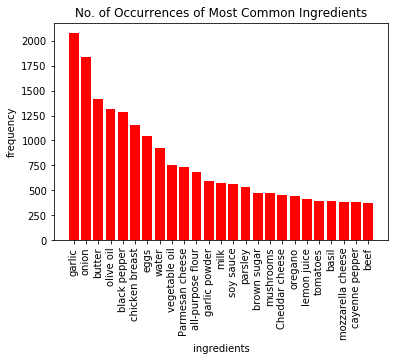

<Figure size 720x1080 with 0 Axes>

In [379]:
# flatten list for count of values
flat_list = [item for sublist in sorted_ings6 for item in sublist]

# create bar chart for 25 most common words
w = Counter(flat_list)
most_occur = w.most_common(25)

word, frequency = zip(*most_occur)
indices = np.arange(len(word))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.xlabel('ingredients')
plt.ylabel('frequency')
plt.title('No. of Occurrences of Most Common Ingredients')
# plt.tight_layout()

plt.figure(figsize=(10,15))
plt.show()

In [361]:
# see frequency of most common terms
w.most_common()

[('garlic', 2079),
 ('onion', 1835),
 ('butter', 1415),
 ('olive oil', 1320),
 ('black pepper', 1281),
 ('chicken breast', 1160),
 ('eggs', 1043),
 ('water', 927),
 ('vegetable oil', 757),
 ('Parmesan cheese', 729),
 ('all-purpose flour', 688),
 ('garlic powder', 591),
 ('milk', 568),
 ('soy sauce', 565),
 ('parsley', 528),
 ('brown sugar', 476),
 ('mushrooms', 470),
 ('Cheddar cheese', 452),
 ('oregano', 438),
 ('lemon juice', 408),
 ('tomatoes', 397),
 ('basil', 388),
 ('mozzarella cheese', 380),
 ('cayenne pepper', 379),
 ('beef', 373),
 ('chicken broth', 366),
 ('Worcestershire sauce', 364),
 ('paprika', 361),
 ('green bell pepper', 341),
 ('sour cream', 333),
 ('cumin', 325),
 ('white sugar', 281),
 ('green onions', 275),
 ('ketchup', 272),
 ('pepper flakes', 269),
 ('cornstarch', 268),
 ('thyme', 265),
 ('cream of mushroom soup', 259),
 ('cilantro', 250),
 ('black pepper to taste', 250),
 ('honey', 247),
 ('lean ground beef', 244),
 ('tomato sauce', 241),
 ('bell pepper', 239),
 

In [187]:
# see how many unique ingredients there are
sorted(w.items())

3598

In [287]:
w.items()

dict_items([('sweet Italian sausage', 8), ('lean ground beef', 244), ('onion', 1835), ('garlic', 2079), ('tomatoes', 397), ('tomato paste', 128), ('tomato sauce', 241), ('water', 927), ('white sugar', 281), ('basil leaves', 67), ('fennel seeds', 12), ('Italian seasoning', 129), ('black pepper', 1281), ('parsley', 528), ('lasagna noodles', 81), ('ricotta cheese', 96), ('eggs', 1043), ('mozzarella cheese', 380), ('Parmesan cheese', 729), ('pork chops', 155), ('paprika', 361), ('butter', 1415), ('mushrooms', 470), ('Dijon mustard', 144), ('all-purpose flour', 688), ('beef broth', 117), ('beef stew meat', 21), ('cream of mushroom soup', 259), ('chives', 43), ('Worcestershire sauce', 364), ('beef bouillon', 43), ('wine', 59), ('cornstarch', 268), ('sour cream', 333), ('cream cheese', 126), ('prime rib roast', 4), ('herbes de Provence', 10), ('canola oil', 66), ('thyme', 265), ('soy sauce', 565), ('chicken broth', 366), ('Sauce:', 9), ('brown sugar', 476), ('honey', 247), ('ginger', 230), ('

In [197]:
df.rename(columns={'total time (min)':'total_time', 'avg. rating':'avg_rating'},inplace=True)
df.drop(columns=['cleaned_ings'],inplace=True)

In [889]:
df.to_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/6k_cleaner.csv',index=False)

In [203]:
pltY = (df.loc[df['total_time'] != 0])
pltX = (pltY.loc[pltY['avg_rating'] != 0])

In [206]:
len(pltX)

5572

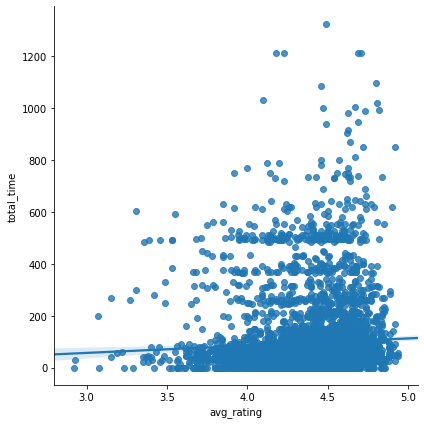

In [231]:
sns.lmplot(x='avg_rating', y='total_time', 
           data=pltX, size=6)

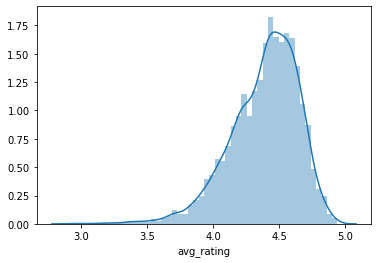

In [209]:
sns.distplot(pltX['avg_rating'])

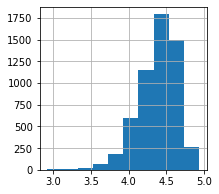

In [225]:
pltX['avg_rating'].hist(figsize=[3,3])

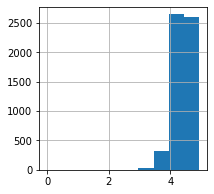

In [216]:
df['avg_rating'].hist(figsize=[3,3])

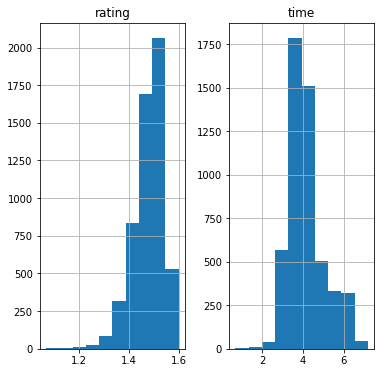

In [223]:
# log transform data

data_log = pd.DataFrame([])
data_log['rating'] = np.log(pltX['avg_rating'])
data_log['time'] = np.log(pltY['total_time'])
data_log.hist(figsize  = [6, 6]);

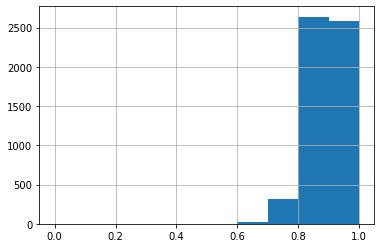

In [228]:
rate = df['avg_rating']

scaled_rate = (rate - min(rate)) / (max(rate) - min(rate))

df_scaled = pd.DataFrame([])
df_scaled['rate'] = scaled_rate

df_scaled['rate'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2b57fc88>,
      dtype=object)

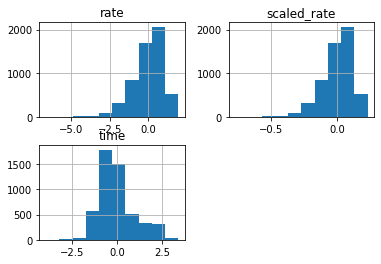

In [233]:
logtime = data_log['time']
lograte = data_log['rating']

scaled_time = (logtime - np.mean(logtime)) / np.sqrt(np.var(logtime))
scaled_rate = (lograte - np.mean(lograte)) / np.sqrt(np.var(lograte))

df_cont = pd.DataFrame([])
df_cont['time'] = scaled_time
df_cont['rate'] = scaled_rate

# mean normalization on rate

scaled_rate1 = (lograte - np.mean(lograte)) / (max(lograte) - min(lograte))
df_cont['scaled_rate'] = scaled_rate1

df_cont.hist()

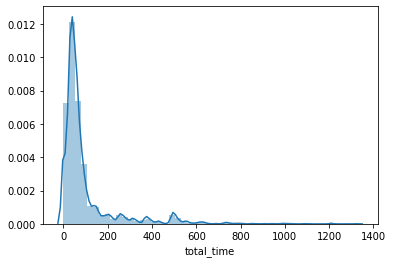

In [210]:
sns.distplot(pltX['total_time'])

### NLP

In [390]:
def generate_ngrams(s, n):
    # Convert to lowercases
#     s = s.lower()
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', '', s)
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [405]:
phrases = []
for valu in df['ings_cleaned'][0]:
    if len(valu) > 10:
        phrases.append(valu)

In [406]:
generate_ngrams(phrases,3)

TypeError: expected string or bytes-like object

In [277]:
# turn list to string
df['ings_str1']=[", ".join(text) for text in df['ings_cleaned'].values]

In [622]:
cleanest_list = df['ings_cleaned'].to_list()

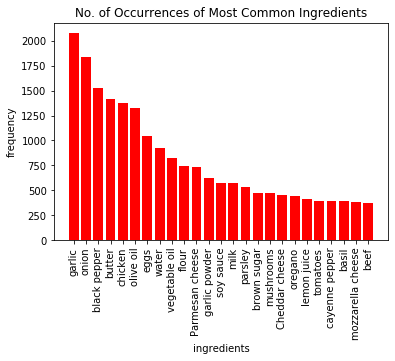

<Figure size 720x1080 with 0 Axes>

In [690]:
# flatten list for count of values
flat_list1 = [item for sublist in leggo1 for item in sublist]

# create bar chart for 25 most common words
w1 = Counter(flat_list1)
most_occur1 = w1.most_common(25)

word1, frequency1 = zip(*most_occur1)
indices1 = np.arange(len(word1))
plt.bar(indices1, frequency1, color='r')
plt.xticks(indices1, word1, rotation='vertical')
plt.xlabel('ingredients')
plt.ylabel('frequency')
plt.title('No. of Occurrences of Most Common Ingredients')
# plt.tight_layout()

plt.figure(figsize=(10,15))
plt.show()

In [609]:
df.sample(20)

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,string
1286,Slow Cooker Lancaster County Pork and Sauerkraut,"['1 (4 pound) pork loin roast', '1 teaspoon caraway seeds', 'salt and pepper to taste', '2 cups sauerkraut with liquid']",380.0,4.43,"[pork loin roast, caraway seeds, sauerkraut with liquid]",pork loin roast caraway seeds sauerkraut with liquid,"pork loin roast, caraway seeds, sauerkraut with liquid","(pork, loin, roast, caraway, seeds, sauerkraut, with, liquid)"
2113,Mondi's Super Simple Chicken,"['4 bone-in chicken breast halves, with skin', '4 tablespoons butter', '1 tablespoon dried basil', '1 teaspoon garlic salt']",0.0,4.26,"[chicken breast, butter, basil]",chicken breast butter basil,"chicken breast, butter, basil","(chicken, breast, butter, basil)"
2116,Fabulous Foolproof Lasagna,"['1 pound Italian sausage, casings removed', '1 pint ricotta cheese', '1 egg, lightly beaten', '1/2 teaspoon dried basil', '1/2 teaspoon dried thyme', '1/2 teaspoon garlic powder', '1/2 teaspoon dried oregano', '8 ounces shredded mozzarella cheese, divided', '1 (16 ounce) jar spaghetti sauce', '12 no-boil lasagna noodles', '3/4 cup grated Parmesan cheese']",60.0,4.29,"[Italian sausage, ricotta cheese, eggs, basil, thyme, garlic powder, oregano, mozzarella cheese, spaghetti sauce, no-boil lasagna noodles, Parmesan cheese]",Italian sausage ricotta cheese eggs basil thyme garlic powder oregano mozzarella cheese spaghetti sauce no-boil lasagna noodles Parmesan cheese,"Italian sausage, ricotta cheese, eggs, basil, thyme, garlic powder, oregano, mozzarella cheese, spaghetti sauce, no-boil lasagna noodles, Parmesan cheese","(Italian, sausage, ricotta, cheese, eggs, basil, thyme, garlic, powder, oregano, mozzarella, cheese, spaghetti, sauce, no, -, boil, lasagna, noodles, Parmesan, cheese)"
1574,Chicken Honey Nut Stir Fry,"['2 teaspoons peanut oil', '2 stalks celery, chopped', '2 carrots, peeled and diagonally sliced', '1 ½ pounds skinless, boneless chicken breast halves - cut into strips', '1 tablespoon cornstarch', '¾ cup orange juice', '3 tablespoons light soy sauce', '1 tablespoon honey', '1 teaspoon minced fresh ginger root', '¼ cup cashews', '¼ cup minced green onions']",20.0,4.17,"[peanut oil, stalks celery, carrots, chicken breast, cornstarch, orange juice, light soy sauce, honey, ginger root, cashews, green onions]",peanut oil stalks celery carrots chicken breast cornstarch orange juice light soy sauce honey ginger root cashews green onions,"peanut oil, stalks celery, carrots, chicken breast, cornstarch, orange juice, light soy sauce, honey, ginger root, cashews, green onions","(peanut, oil, stalks, celery, carrots, chicken, breast, cornstarch, orange, juice, light, soy, sauce, honey, ginger, root, cashews, green, onions)"
128,Mushroom Pork Chops,"['4 pork chops', 'salt and pepper to taste', '1 pinch garlic salt, or to taste', '1 onion, chopped', '1/2 pound fresh mushrooms, sliced', '1 (10.75 ounce) can condensed cream of mushroom soup']",40.0,4.43,"[pork chops, onion, mushrooms, cream of mushroom soup]",pork chops onion mushrooms cream of mushroom soup,"pork chops, onion, mushrooms, cream of mushroom soup","(pork, chops, onion, mushrooms, cream, of, mushroom, soup)"
4733,Oven-Seared Beef Tenderloin with Herb Pan Sauce,"['2 beef tenderloin steaks (1 1/2 inches thick)', '1/4 teaspoon kosher salt', '1/2 teaspoon coarsely ground pepper', '2 tablespoons vegetable oil', 'Herb Pan Sauce:', '1 tablespoon unsalted butter', '2 tablespoons finely diced shallots', '1 tablespoon deli-style brown mustard', '1 cup Swanson® Beef Stock', '1 tablespoon Worcestershire sauce', '2 tablespoons heavy cream', '2 teaspoons chopped fresh parsley', '1 teaspoon chopped fresh chives', '1 teaspoon chopped fresh thyme', '1 teaspoon chopped fresh oregano']",50.0,4.88,"[beef tenderloin steaks, pepper, vegetable oil, Herb Pan Sauce:, butter, shallots, deli-style brown mustard, Swanson® Beef Stock, Worcestershire sauce, heavy cream, parsley, c

In [414]:
import re
from nltk.util import ngrams

s = str(df['ings_cleaned'][2290])
s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
tokens = [token for token in s.split(" ") if token != ""]
output = list(ngrams(tokens, 3))

In [1025]:
leggon = []
for values in df['ings_cleaned'].to_list():
    helping = []
    deleting = []
    for string in values:
        if ':' in string:
            deleting.append(string)
        else:
            helping.append(string)
    leggon.append(helping)
       
    
#         else:
#             helping.append(string.strip())
#     leggo.append(helping)


In [1026]:
leggon

[['sweet Italian sausage',
  'lean ground beef',
  'onion',
  'garlic',
  'tomatoes',
  'tomato paste',
  'tomato sauce',
  'water',
  'white sugar',
  'basil leaves',
  'fennel seeds',
  'Italian seasoning',
  'black pepper',
  'parsley',
  'lasagna noodles',
  'ricotta cheese',
  'eggs',
  'mozzarella cheese',
  'Parmesan cheese'],
 ['pork chops',
  'paprika',
  'butter',
  'mushrooms',
  'garlic',
  'Dijon mustard',
  'all-purpose flour',
  'beef broth'],
 ['beef stew meat',
  'onion',
  'cream of mushroom soup',
  'water',
  'chives',
  'garlic',
  'Worcestershire sauce',
  'beef bouillon',
  'wine',
  'cornstarch',
  'all-purpose flour',
  'sour cream',
  'mushrooms',
  'cream cheese',
  'parsley'],
 ['prime rib roast', 'butter', 'black pepper', 'herbes de Provence'],
 ['canola oil',
  'onion',
  'beef stew meat',
  'black pepper',
  'garlic',
  'thyme',
  'soy sauce',
  'mushrooms',
  'all-purpose flour',
  'chicken broth',
  'eggs',
  'sour cream'],
 ['water',
  'soy sauce',
  '

In [629]:
leggo = []
for values in df['ings_cleaned'].to_list():
    helping = []
    for string in values:
        if ('chicken breast') in string:
            helping.append('chicken')
        else:
            helping.append(string.strip())
    leggo.append(helping)

In [632]:
df['cleaned_ings'] = leggo
df.sample(20)

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,string,cleaned_ings
2156,Grilled Swordfish with Rosemary,"['1/2 cup white wine', '5 cloves garlic, minced', '2 teaspoons chopped fresh rosemary', '4 (4 ounce) swordfish steaks', '1/4 teaspoon salt', '1/4 teaspoon ground black pepper', '2 tablespoons lemon juice', '1 tablespoon extra virgin olive oil', '4 slices lemon, for garnish']",80.0,4.35,"[white wine, garlic, rosemary, swordfish steaks, black pepper, lemon juice, virgin olive oil, lemon]",white wine garlic rosemary swordfish steaks black pepper lemon juice virgin olive oil lemon,"white wine, garlic, rosemary, swordfish steaks, black pepper, lemon juice, virgin olive oil, lemon","(white, wine, garlic, rosemary, swordfish, steaks, black, pepper, lemon, juice, virgin, olive, oil, lemon)","[white wine, garlic, rosemary, swordfish steaks, black pepper, lemon juice, virgin olive oil, lemon]"
4954,Leg of Lamb,"['8 pounds whole leg of lamb', 'salt to taste', 'ground black pepper to taste', '6 ounces prepared mustard', '1 dash Worcestershire sauce', '2 tablespoons all-purpose flour', '4 cloves garlic, sliced (optional)']",0.0,4.43,"[leg of lamb, black pepper to taste, mustard, Worcestershire sauce, all-purpose flour, garlic]",leg of lamb black pepper to taste mustard Worcestershire sauce all-purpose flour garlic,"leg of lamb, black pepper to taste, mustard, Worcestershire sauce, all-purpose flour, garlic","(leg, of, lamb, black, pepper, to, taste, mustard, Worcestershire, sauce, all, -, purpose, flour, garlic)","[leg of lamb, black pepper to taste, mustard, Worcestershire sauce, all-purpose flour, garlic]"
1734,Cheesy Pork Chop Casserole,"['4 potatoes, peeled and sliced', '4 thick cut boneless pork chops', '1 (10.75 ounce) can condensed Cheddar cheese soup', '1 (10.5 ounce) can condensed French onion soup', '1 (8 ounce) package shredded Monterey Jack cheese']",75.0,3.97,"[potatoes, thick cut pork chops, Cheddar cheese soup, French onion soup, Monterey Jack cheese]",potatoes thick cut pork chops Cheddar cheese soup French onion soup Monterey Jack cheese,"potatoes, thick cut pork chops, Cheddar cheese soup, French onion soup, Monterey Jack cheese","(potatoes, thick, cut, pork, chops, Cheddar, cheese, soup, French, onion, soup, Monterey, Jack, cheese)","[potatoes, thick cut pork chops, Cheddar cheese soup, French onion soup, Monterey Jack cheese]"
3213,Vegetarian Chickpea Curry with Turnips,"['2 tablespoons olive oil', '1/2 onion, diced', '2 cloves garlic, minced', '1 tablespoon ground cumin', '2 tablespoons curry powder', '1 (15 ounce) can garbanzo beans (chickpeas), undrained', '1/2 red bell pepper, diced', '1/2 turnip, peeled and diced', '1 cup corn kernels', '1/2 (15 ounce) can tomato sauce', '1 pinch crushed red pepper flakes (optional)', '1 pinch salt', '1 pinch cracked black pepper']",125.0,4.57,"[olive oil, onion, garlic, cumin, curry powder, garbanzo beans, bell pepper, turnip, corn kernels, tomato sauce, pepper flakes, black pepper]",olive oil onion garlic cumin curry powder garbanzo beans bell pepper turnip corn kernels tomato sauce pepper flakes black pepper,"olive oil, onion, garlic, cumin, curry powder, garbanzo beans, bell pepper, turnip, corn kernels, tomato sauce, pepper flakes, black pepper","(olive, oil, onion, garlic, cumin, curry, powder, garbanzo, beans, bell, pepper, turnip, corn, kernels, tomato, sauce, pepper, flakes, black, pepper)","[olive oil, onion, garlic, cumin, curry powder, garbanzo beans, bell pepper, turnip, corn kernels, tomato sauce, pepper flakes, black pepper]"
2392,Grilled Mahi Mahi,"['5 pounds skinned, deboned mahi mahi, cut into chunks', '3/4 (4.5 ounce) jar bottled minced garlic', '1/2 cup butter, diced', '1 large onion, diced', '1 1/2 lemons, juiced', '1/2 cup dry white wine', '1 1/2 (10 ounce) cans diced tomatoes with green chile peppers', 'salt and pepper to taste', '8 ounces shredded pepperjack cheese']",55.0,4.40,"[mahi mahi, garlic, butter, onion, lemons, dry white

In [1016]:
empty = []
for values in df['cleaned_ings'].to_list():
    helping = []
    for string in values:
        if ':' in string:
            empty.append(string.strip(string))

In [1023]:
real_one = []
for ins in empty:
    if len(ins) != 0:
        real_one.append(ins)

In [ ]:
#and, ), cut into, or, -, bulk, large, of your choice, glutinous, dry, Fritos® , into
# 1/2-inch slices, meat, matchsticks, dry, - cut, pieces, ******(some are just center-cut or center cut), (cod) loin
# pple
# luminum, low fat, :
#feta cheese with basil and sun- tomatoes
# warm and pepper now

# granular nocalorie sucralose ener & artificial - change to sweetener

In [1011]:
leggo1 = []
for values in df['cleaned_ings'].to_list():
    helping = []
    for string in values:
        if 'shrimp' in string:
            helping.append(string.replace('-','').replace('d rock ','').replace('baby','').replace('without tails','').replace('cocktail','').replace('cream of','').replace('soup','').replace('d jumbo','').replace('or raw','').replace('in shell','').replace('medium','').replace('raw','').replace('colossal','').replace('salad','').replace('d shrimp','shrimp').replace('stock or','').replace('d  shrimp','shrimp').replace('shellon jumbo shrimp','shrimp').replace('d small shrimp','shrimp').strip())
    
        else:
            helping.append(string.strip())
    leggo1.append(helping)

In [1031]:
df['cleaned_ings'] = leggo1

In [1035]:
df.sample(20)

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,string,cleaned_ings
2833,Tennessee Meatloaf,"['Brown Sugar Glaze:', '1/2 cup ketchup', '1/4 cup brown sugar', '2 tablespoons cider vinegar', 'Meatloaf:', 'cooking spray', '1 onion, chopped', '1/2 green bell pepper, chopped', '2 cloves garlic, minced', '2 large eggs, lightly beaten', '1 teaspoon dried thyme', '1 teaspoon seasoned salt', '1/2 teaspoon ground black pepper', '2 teaspoons prepared mustard', '2 teaspoons Worcestershire sauce', '1/2 teaspoon hot pepper sauce (such as Tabasco®)', '1/2 cup milk', '2/3 cup quick cooking oats', '1 pound ground beef', '1/2 pound ground pork', '1/2 pound ground veal']",115.0,4.54,"[Brown Sugar Glaze:, ketchup, brown sugar, cider vinegar, Meatloaf:, cooking spray, onion, green bell pepper, garlic, eggs, thyme, black pepper, mustard, Worcestershire sauce, hot pepper sauce, milk, cooking oats, beef, pork, veal]",Brown Sugar Glaze: ketchup brown sugar cider vinegar Meatloaf: cooking spray onion green bell pepper garlic eggs thyme black pepper mustard Worcestershire sauce hot pepper sauce milk cooking oats beef pork veal,"Brown Sugar Glaze:, ketchup, brown sugar, cider vinegar, Meatloaf:, cooking spray, onion, green bell pepper, garlic, eggs, thyme, black pepper, mustard, Worcestershire sauce, hot pepper sauce, milk, cooking oats, beef, pork, veal","(Brown, Sugar, Glaze, :, ketchup, brown, sugar, cider, vinegar, Meatloaf, :, cooking, spray, onion, green, bell, pepper, garlic, eggs, thyme, black, pepper, mustard, Worcestershire, sauce, hot, pepper, sauce, milk, cooking, oats, beef, pork, veal)","[Brown Sugar Glaze:, ketchup, brown sugar, cider vinegar, Meatloaf:, cooking spray, onion, green bell pepper, garlic, eggs, thyme, black pepper, mustard, Worcestershire sauce, hot pepper sauce, milk, cooking oats, beef, pork, veal]"
1588,Santa Maria Grilled Tri-Tip Beef,"['2 teaspoons salt', '2 teaspoons freshly ground black pepper', '2 teaspoons garlic powder', '1 1/2 teaspoons paprika', '1 teaspoon onion powder', '1 teaspoon dried rosemary', '1/4 teaspoon cayenne pepper', '1 (2 1/2 pound) beef tri-tip roast', '1/3 cup red wine vinegar', '1/3 cup vegetable oil', '4 cloves crushed garlic', '1/2 teaspoon Dijon mustard']",315.0,4.81,"[black pepper, garlic powder, paprika, onion powder, rosemary, cayenne pepper, beef tri-tip roast, wine vinegar, vegetable oil, garlic, Dijon mustard]",black pepper garlic powder paprika onion powder rosemary cayenne pepper beef tri-tip roast wine vinegar vegetable oil garlic Dijon mustard,"black pepper, garlic powder, paprika, onion powder, rosemary, cayenne pepper, beef tri-tip roast, wine vinegar, vegetable oil, garlic, Dijon mustard","(black, pepper, garlic, powder, paprika, onion, powder, rosemary, cayenne, pepper, beef, tri, -, tip, roast, wine, vinegar, vegetable, oil, garlic, Dijon, mustard)","[black pepper, garlic powder, paprika, onion powder, rosemary, cayenne pepper, beef tri-tip roast, wine vinegar, vegetable oil, garlic, Dijon mustard]"
5187,Sour Cream Chops,"['2 tablespoons butter', '4 thick cut pork chops', '1/2 teaspoon salt', '1/2 teaspoon black pepper', '1 onion, sliced into rings', '2 cloves garlic, finely chopped', '1/4 cup fresh basil, chopped', '1 large fresh tomato, chopped', '5 large fresh mushrooms, sliced', '1/2 cup milk', '1 (10.5 ounce) can condensed cream of chicken soup', '4 teaspoons sour cream']",100.0,4.54,"[butter, thick cut pork chops, black pepper, onion, garlic, basil, tomato, mushrooms, milk, cream of chicken soup, sour cream]",butter thick cut pork chops black pepper onion garlic basil tomato mushrooms milk cream of chicken soup sour cream,"butter, thick cut pork chops, black pepper, onion, garlic, basil, tomato, mushrooms, milk, cream of chicken soup, sour cream","(butter, thick, cut, pork, chops, black, pepper, onion, garlic, basil, tomato, mushrooms, milk, cream, of, chicken, soup, sour, cream)","[butter, pork chops, black pepper, onion, garlic, basil, tomato, mus

In [1033]:
df.to_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/6k_cleaner.csv',index=False)

In [734]:
leggo1

[['sweet Italian sausage',
  'lean ground beef',
  'onion',
  'garlic',
  'tomatoes',
  'tomato paste',
  'tomato sauce',
  'water',
  'white sugar',
  'basil leaves',
  'fennel seeds',
  'Italian seasoning',
  'black pepper',
  'parsley',
  'lasagna noodles',
  'ricotta cheese',
  'eggs',
  'mozzarella cheese',
  'Parmesan cheese'],
 ['pork chops',
  'paprika',
  'butter',
  'mushrooms',
  'garlic',
  'Dijon mustard',
  'flour',
  'beef broth'],
 ['beef stew meat',
  'onion',
  'cream of mushroom soup',
  'water',
  'chives',
  'garlic',
  'Worcestershire sauce',
  'beef bouillon',
  'wine',
  'cornstarch',
  'flour',
  'sour cream',
  'mushrooms',
  'cream cheese',
  'parsley'],
 ['prime rib roast', 'butter', 'black pepper', 'herbes de Provence'],
 ['canola oil',
  'onion',
  'beef stew meat',
  'black pepper',
  'garlic',
  'thyme',
  'soy sauce',
  'mushrooms',
  'flour',
  'chicken broth',
  'eggs',
  'sour cream'],
 ['Sauce:',
  'water',
  'soy sauce',
  'brown sugar',
  'honey',

In [597]:
output

[('all', 'purpose', 'flour'),
 ('purpose', 'flour', 'garlic'),
 ('flour', 'garlic', 'powder'),
 ('garlic', 'powder', 'onion'),
 ('powder', 'onion', 'powder'),
 ('onion', 'powder', 'coarse'),
 ('powder', 'coarse', 'ground'),
 ('coarse', 'ground', 'black'),
 ('ground', 'black', 'pepper'),
 ('black', 'pepper', 'eggs'),
 ('pepper', 'eggs', 'buttermilk'),
 ('eggs', 'buttermilk', 'barbeque'),
 ('buttermilk', 'barbeque', 'sauce'),
 ('barbeque', 'sauce', 'Worcestershire'),
 ('sauce', 'Worcestershire', 'sauce'),
 ('Worcestershire', 'sauce', 'steak'),
 ('sauce', 'steak', 'sauce'),
 ('steak', 'sauce', 'chicken'),
 ('sauce', 'chicken', 'oil'),
 ('chicken', 'oil', 'for'),
 ('oil', 'for', 'frying')]

In [713]:
df

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,string,cleaned_ings
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']",195.0,4.80,"[sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese]",sweet Italian sausage lean ground beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leaves fennel seeds Italian seasoning black pepper parsley lasagna noodles ricotta cheese eggs mozzarella cheese Parmesan cheese,"sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese","(sweet, Italian, sausage, lean, ground, beef, onion, garlic, tomatoes, tomato, paste, tomato, sauce, water, white, sugar, basil, leaves, fennel, seeds, Italian, seasoning, black, pepper, parsley, lasagna, noodles, ricotta, cheese, eggs, mozzarella, cheese, Parmesan, cheese)","[sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese]"
1,Pork Chops in Garlic Mushroom Sauce,"['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']",30.0,4.61,"[pork chops, paprika, butter, mushrooms, garlic, Dijon mustard, all-purpose flour, beef broth]",pork chops paprika butter mushrooms garlic Dijon mustard all-purpose flour beef broth,"pork chops, paprika, butter, mushrooms, garlic, Dijon mustard, all-purpose flour, beef broth","(pork, chops, paprika, butter, mushrooms, garlic, Dijon, mustard, all, -, purpose, flour, beef, broth)","[pork chops, paprika, butter, mushrooms, garlic, Dijon mustard, flour, beef broth]"
2,Super Duper Slow Cooker Beef Stroganoff,"['1 1/2 pounds cubed beef stew meat', 'salt and ground black pepper to taste', '1 onion, chopped', '1 (10.75 ounce) can condensed cream of mushroom soup', '1/4 cup water', '1 tablespoon dried chives', '2 cloves garlic, minced', '1 tablespoon Worcestershire sauce', '1 cube beef bouillon', '1/2 cup red wine', '1 tablespoon cornstarch', '1 tablespoon all-purpose flour', '1 (8 ounce) container sour cream', '1 (8 ounce) package sliced fresh mushrooms', '4 ounces cream cheese', '1/2 cup chopped fresh parsley']",435.0,4.63,"[beef stew meat, onion, cream of mushroom soup, water, chives, garlic, Worcestershire sauce, beef bouillon, wine, cornstarch, all-purpose flour, sour cream, mushrooms, cream cheese, parsley]",beef stew meat onion cream of mushroom soup water chives garlic Worcestershire sauce beef bouillon wine cornstarch all-purpose flour sour cream mushrooms cream cheese parsley,"beef stew meat, onion, cream of mushroom soup, water, chives, garlic, Worcestershire sauce, beef bouillon, wine, cornstarch, all-purpose flour, sour cream, mushrooms, cream cheese, parsley","(beef

In [596]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = []
for values in df['ings_cleaned']:
    print(nlp(values))

# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#             token.shape_, token.is_alpha, token.is_stop)

TypeError: object of type 'zip' has no len()

In [ ]:
doc